In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.cm import get_cmap

In [2]:
current_directory = os.getcwd()
parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
dataset_dir = os.path.join(parent_directory,"Datasets")

In [3]:
players_df = pd.read_csv(f"{dataset_dir}/players.csv")
bowling_scores_df = pd.read_csv(f"{dataset_dir}/bowling_scores.csv")
fixtures_df = pd.read_csv(f"{dataset_dir}/fixtures.csv")
teams_df = pd.read_csv(f"{dataset_dir}/teams.csv")
points_table_df = pd.read_csv(f"{dataset_dir}/points.csv")

In [4]:
bowling_scores_df

,player_name,player_id,team_id,match_id,innings,overs,maidens,runs,wickets,economy,wides,no_ball
0,Trent Boult,108,7,1,1,10.0,1,48,1,4.80,1,0
1,Matt Henry,113,7,1,1,10.0,1,48,3,4.80,0,0
2,Mitchell Santner,107,7,1,1,10.0,0,37,2,3.70,1,0
3,James Neesham,104,7,1,1,7.0,0,56,0,8.00,2,0
4,Rachin Ravindra,106,7,1,1,10.0,0,76,1,7.60,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
569,Jasprit Bumrah,76,5,48,2,9.0,2,43,2,4.77,0,0
570,Mohammed Shami,78,5,48,2,7.0,1,47,1,6.71,3,0
571,Ravindra Jadeja,73,5,48,2,10.0,0,43,0,4.30,1,0
572,Kuldeep Yadav,77,5,48,2,10.0,0,56,0,5.60,0,0


## Top Wicket Takers in the Tournament

/tmp/ipykernel_71681/407202397.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis', num_bars)


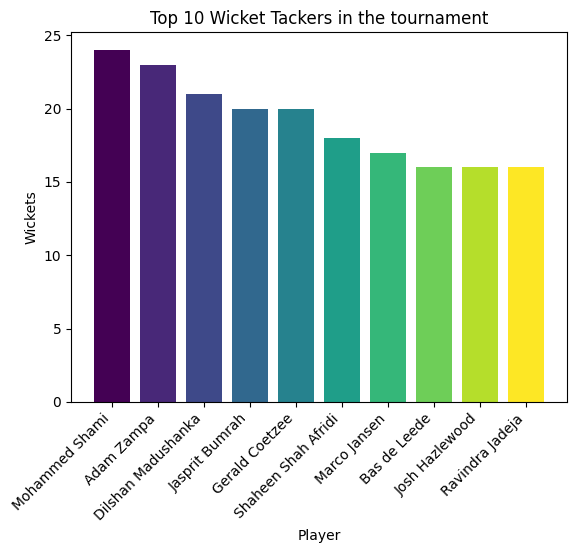

In [42]:
top_wickets_agg = (
    bowling_scores_df.groupby("player_id")
    .agg(
        **{
            "player_name": ("player_name", "first"), 
            "team_id": ("team_id", "first"), 
            "wickets": ("wickets", "sum"), 
            "innings": ("player_id", "size"),
            "runs_conceded": ("runs", "sum")
        }
    )
    .reset_index()
)

top_wickets_agg["average"] = (top_wickets_agg["runs_conceded"] / top_wickets_agg["wickets"]).round(2)

top_wickets_takers = (
    pd.merge(top_wickets_agg, teams_df[["team_id", "team_name"]], on="team_id")
    .sort_values(by="wickets", ascending=False)
    .reset_index()
)

top_10_wickets_takers = top_wickets_takers[["player_name", "team_name", "wickets", "innings", "average"]].head(10)


num_bars = len(top_10_wickets_takers["player_name"])
cmap = get_cmap('viridis', num_bars)

fig, ax = plt.subplots()
bars = ax.bar(top_10_wickets_takers["player_name"], top_10_wickets_takers["wickets"], color=cmap(range(num_bars)))

plt.xlabel('Player')
plt.ylabel('Wickets')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Wicket Tackers in the tournament')
plt.show()

## Most Wickets by Countries

In [6]:
team_wickets = bowling_scores_df.groupby("team_id").agg({"wickets": "sum"}).reset_index()
team_wickets_df = pd.merge(team_wickets, teams_df[["team_id", "team_name"]], on="team_id")
team_wickets_df[["team_name", "wickets"]].sort_values(by="wickets", ascending=False)

,team_name,wickets
4,India,99
8,South Africa,88
1,Australia,86
6,New Zealand,71
3,England,65
7,Pakistan,65
5,Netherlands,62
0,Afghanistan,53
2,Bangladesh,51
9,Sri Lanka,50


## Best Figures in a Match

In [7]:
most_wickets_in_a_match = bowling_scores_df.iloc[bowling_scores_df["wickets"].idxmax()]
match = fixtures_df[fixtures_df["match_id"] == most_wickets_in_a_match["match_id"]]
opposition_team_id = np.where(match['team_one_id'] == most_wickets_in_a_match["team_id"], match['team_two_id'], match['team_one_id'])[0]
opposition_team = teams_df.loc[teams_df["team_id"] == opposition_team_id, "team_name"].values[0]
print(f"Best Figures in a match")
print(f"{most_wickets_in_a_match['player_name']} vs {opposition_team}")
print(f"Figures: {most_wickets_in_a_match['wickets']}/{most_wickets_in_a_match['runs']}")

Best Figures in a match
Mohammed Shami vs New Zealand
Figures: 7/57


## Most Fifers

In [8]:
fifers_agg = (
    bowling_scores_df.groupby("player_id").agg(
        **{
            "player_name": ("player_name", "first"),
            "team_id": ("team_id", "first"),
            "fifers": ("wickets", lambda x: (x >= 5).sum()),
            "innings": ("player_id", "size"),
        }
    )
).reset_index()
fifers_df = (
    pd.merge(fifers_agg, teams_df[["team_id", "team_name"]], on="team_id")
    .sort_values(by="fifers", ascending=False)
    .query("fifers > 0")
    .reset_index()
)
fifers_df[["player_name", "team_name", "innings", "fifers"]]


,player_name,team_name,innings,fifers
0,Mohammed Shami,India,7,3
1,Shaheen Shah Afridi,Pakistan,9,1
2,Dilshan Madushanka,Sri Lanka,9,1
3,Ravindra Jadeja,India,11,1
4,Mitchell Santner,New Zealand,10,1


## Best Bowling Average (Minimum 5 Innings)

In [9]:
bowling_stats_agg = (
    bowling_scores_df.groupby("player_id")
    .agg(
        **{
            "player_name": ("player_name", "first"), 
            "team_id": ("team_id", "first"), 
            "wickets": ("wickets", "sum"), 
            "innings": ("player_id", "size"),
            "runs_conceded": ("runs", "sum"),
            "overs_bowled": ("overs", "sum")
        }
    )
    .reset_index()
).query("innings >= 5")

bowling_stats_agg["economy"] = (bowling_stats_agg["runs_conceded"] / bowling_stats_agg["overs_bowled"]).round(2)
bowling_stats_agg["average"] = (bowling_stats_agg["runs_conceded"] / bowling_stats_agg["wickets"]).round(2)

bowling_stats_agg.sort_values(by="economy", ascending=True).head(10)

,player_id,player_name,team_id,wickets,innings,runs_conceded,overs_bowled,economy,average
46,76,Jasprit Bumrah,5,20,11,373,91.5,4.08,18.65
1,8,Mohammad Nabi,1,8,9,254,61.3,4.14,31.75
84,139,Keshav Maharaj,9,15,10,370,89.0,4.16,24.67
44,73,Ravindra Jadeja,5,16,11,398,92.9,4.28,24.88
47,77,Kuldeep Yadav,5,15,11,424,95.1,4.46,28.27
3,10,Rashid Khan,1,11,9,388,86.3,4.50,35.27
8,17,Travis Head,2,2,5,101,21.0,4.81,50.50
15,28,Josh Hazlewood,2,16,11,449,93.1,4.82,28.06
12,25,Glenn Maxwell,2,6,8,330,68.3,4.83,55.00
93,155,Angelo Mathews,10,6,5,107,22.1,4.84,17.83


## Most No Balls Bowled

In [10]:
extras_stats_agg = (
    bowling_scores_df.groupby("player_id")
    .agg(
        {
            "player_name": "first", 
            "team_id": "first", 
            "wides": "sum",
            "no_ball": "sum"
        }
    )
    .reset_index()
)

extras_stats_agg["extras"] = extras_stats_agg["wides"] + extras_stats_agg["no_ball"]

extras_stats_agg[["player_name", "no_ball"]].sort_values(by="no_ball", ascending=False).reset_index(drop=True).head(15)

,player_name,no_ball
0,Kagiso Rabada,5
1,Marco Jansen,5
2,Paul van Meekeren,3
3,Tabraiz Shamsi,3
4,Dilshan Madushanka,3
5,Matt Henry,3
6,Ravindra Jadeja,2
7,Gerald Coetzee,2
8,Sam Curran,2
9,Hasan Ali,2


## Most Extras Given By Bowler

In [11]:
extras_stats_agg[["player_name", "extras"]].sort_values(by="extras", ascending=False).reset_index(drop=True).head(15)

,player_name,extras
0,Marco Jansen,41
1,Mitchell Starc,41
2,Dilshan Madushanka,26
3,Logan van Beek,25
4,Lungi Ngidi,24
5,Shaheen Shah Afridi,22
6,Jasprit Bumrah,22
7,Bas de Leede,20
8,Paul van Meekeren,20
9,Trent Boult,19


## Most Runs Conceded in a Match

In [39]:
most_runs_in_a_match = bowling_scores_df.iloc[bowling_scores_df["runs"].idxmax()]
match = fixtures_df[fixtures_df["match_id"] == most_runs_in_a_match["match_id"]]
opposition_team_id = np.where(match['team_one_id'] == most_runs_in_a_match["team_id"], match['team_two_id'], match['team_one_id'])[0]
opposition_team = teams_df.loc[teams_df["team_id"] == opposition_team_id, "team_name"].values[0]
print(f"Best Figures in a match")
print(f"{most_runs_in_a_match['player_name']} vs {opposition_team}")
print(f"Figures: {most_runs_in_a_match['wickets']}/{most_runs_in_a_match['runs']}")
print(f"Figures: {most_runs_in_a_match['overs']}")
print(f"Economy: {most_runs_in_a_match['economy']}")

Best Figures in a match
Bas de Leede vs Australia
Figures: 2/115
Figures: 10.0
Economy: 11.5


## Most Runs Conceded in the Tournament

In [34]:
most_runs_agg = (
    bowling_scores_df.groupby("player_id")
    .agg(
        **{
            "player_name": ("player_name", "first"),
            "team_id": ("team_id", "first"),
            "runs_conceded": ("runs", "sum"),
            "wides": ("wides", "sum"),
            "no_balls": ("no_ball", "sum")
        }
    )
).reset_index()

most_runs_df = (
    pd.merge(most_runs_agg, teams_df[["team_id","team_name"]], on="team_id")
    .sort_values(by="runs_conceded", ascending=False)
)

most_runs_df[["player_name", "team_name", "runs_conceded", "wides", "no_balls"]].head(10)

,player_name,team_name,runs_conceded,wides,no_balls
76,Haris Rauf,Pakistan,533,18,0
16,Mitchell Starc,Australia,528,41,0
96,Dilshan Madushanka,Sri Lanka,525,23,3
17,Adam Zampa,Australia,515,9,0
14,Pat Cummins,Australia,515,14,1
66,Trent Boult,New Zealand,504,19,0
53,Bas de Leede,Netherlands,487,18,2
78,Shaheen Shah Afridi,Pakistan,481,22,0
58,Logan van Beek,Netherlands,476,24,1
49,Mohammed Siraj,India,469,17,0


## Stats By Bowler

In [22]:
def check_bowling_stats(player_name):
    player_id = players_df.loc[players_df["name"] == player_name, "player_id"].values[0]
    bowler_matches = bowling_scores_df[bowling_scores_df["player_id"] == player_id]
    
    total_runs = bowler_matches.groupby("player_id").agg({"runs": "sum", "wides": "sum", "no_ball": "sum"})
    
    print(f"Total runs conceded (including extras): {total_runs['runs'].values[0]} runs")
    print(f"\nScores conceded per match")
    
    
    runs_per_match = []
    teams = []
    for index, row in bowler_matches.iterrows():
        match = fixtures_df[fixtures_df["match_id"] == row["match_id"]]
        opposition_team_id = np.where(match['team_one_id'] == row["team_id"], match['team_two_id'], match['team_one_id'])[0]
        team_name = teams_df[teams_df['team_id'] == opposition_team_id]['team_name'].values[0]
        runs_per_match.append(row['runs'])
        teams.append(team_name)

        print(f"vs {team_name}")
        print(f"Overs: {row['overs']}")
        print(f"Figures: {row['wickets']}/{row['runs']}")
        print(f"Economy: {row['economy']}")
        print("\n")

    num_bars = len(runs_per_match)
    cmap = get_cmap('viridis', num_bars)

    fig, ax = plt.subplots()
    bars = ax.bar(teams, runs_per_match, color=cmap(range(num_bars)))

    plt.xlabel('Teams')
    plt.ylabel('Runs')
    plt.xticks(rotation=45, ha='right')
    plt.title('Runs conceded against Teams')
    plt.show()

Total runs conceded (including extras): 528 runs

Scores conceded per match
vs India
Overs: 8.0
Figures: 1/31
Economy: 3.87


vs South Africa
Overs: 9.0
Figures: 2/53
Economy: 5.88


vs Sri Lanka
Overs: 10.0
Figures: 2/43
Economy: 4.3


vs Pakistan
Overs: 8.0
Figures: 1/65
Economy: 8.12


vs Netherlands
Overs: 4.0
Figures: 1/22
Economy: 5.5


vs New Zealand
Overs: 9.0
Figures: 0/89
Economy: 9.88


vs England
Overs: 10.0
Figures: 2/66
Economy: 6.6


vs Afghanistan
Overs: 9.0
Figures: 1/70
Economy: 7.77


vs South Africa
Overs: 10.0
Figures: 3/34
Economy: 3.4


vs India
Overs: 10.0
Figures: 3/55
Economy: 5.5




/tmp/ipykernel_71681/1014292824.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis', num_bars)


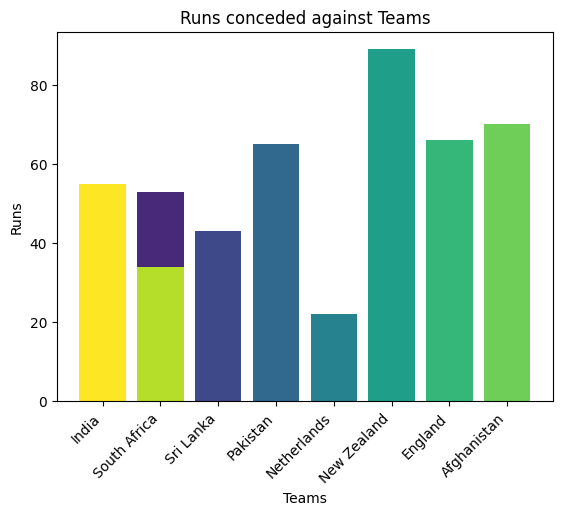

In [23]:
check_bowling_stats("Mitchell Starc")